In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
sns.set(style="whitegrid")

In [12]:
df = pd. read_csv("Fraud_table.csv")


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [14]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:
df.tail()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [16]:
df = df.rename(columns={'newbalanceOrig': 'newbalanceOrg', 'nameOrig': 'nameOrg'})

In [17]:
df.isna().sum()

step              0
type              0
amount            0
nameOrg           0
oldbalanceOrg     0
newbalanceOrg     0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [19]:
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows:,}")
print("Number of columns:", num_columns)

Number of rows: 6,362,620
Number of columns: 11


In [20]:
#Define custom colors
light_orange = '#ffd699'
light_red = '#ff9999'

In [21]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


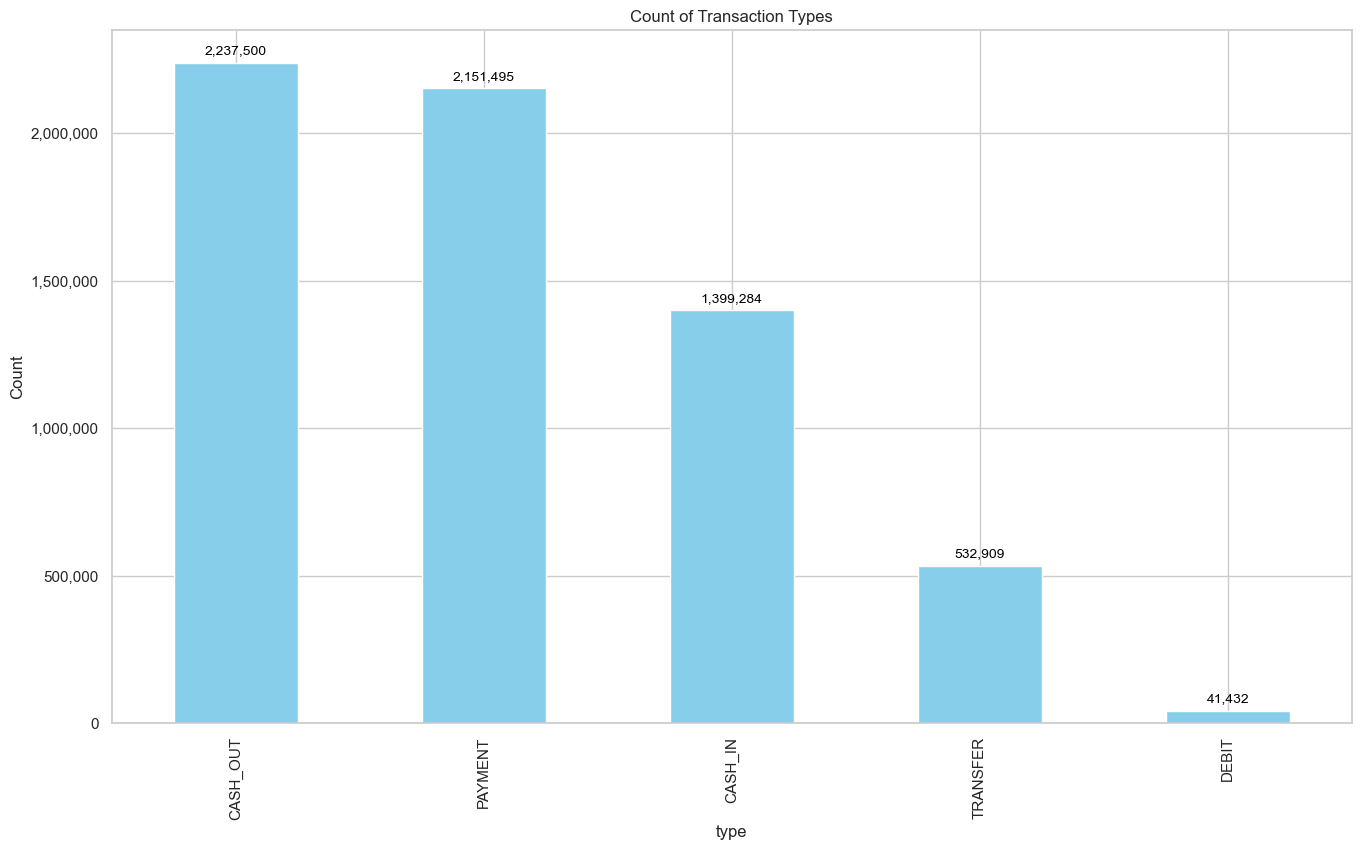

In [22]:
plt.figure(figsize=(16, 9))
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
bars = type_counts.plot(kind='bar', color='skyblue')

# Add data labels on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20000, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Format count axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))
plt.show()

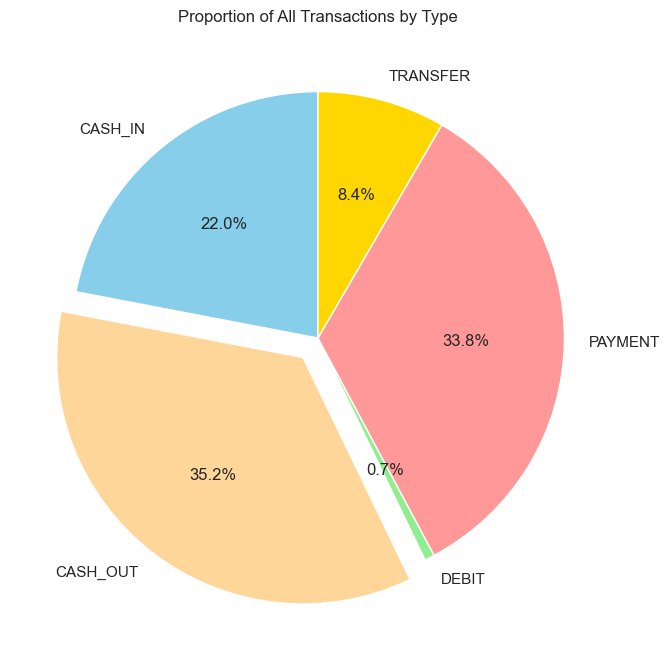

In [23]:
all_counts_by_type = df.groupby("type").size()
plt.figure(figsize=(8, 8))
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', light_orange, 'lightgreen', light_red, 'gold'], explode=(0, 0.1, 0, 0, 0))
plt.title('Proportion of All Transactions by Type')
plt.show()

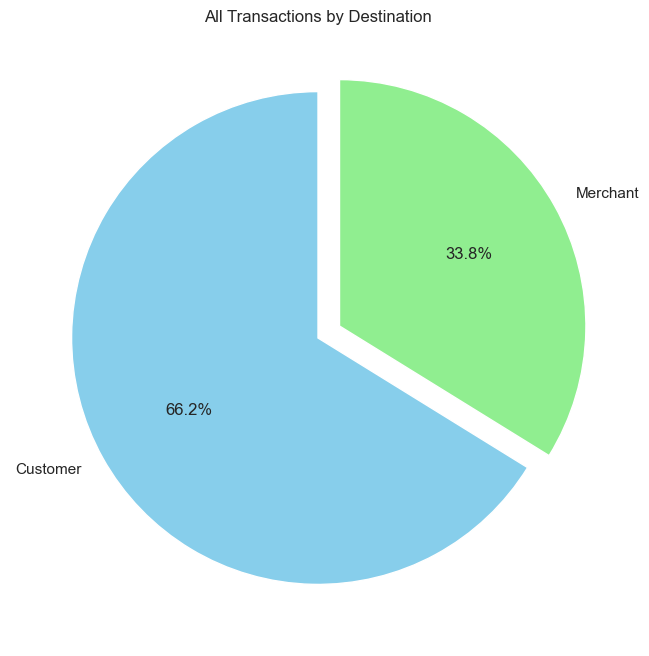

In [24]:
df_copy = df.copy();
df_copy['nameDest_first_letter'] = df_copy['nameDest'].str[0]
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('C', 'Customer')
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('M', 'Merchant')
all_by_dest = df_copy.groupby('nameDest_first_letter').size()

plt.figure(figsize=(8, 8))
plt.pie(all_by_dest, labels=all_by_dest.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'], explode=(0, 0.1))
plt.title('All Transactions by Destination')
plt.show()

In [25]:
fraud_count = df[df["isFraud"] == 1].shape[0]
non_fraud_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraud_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraud_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


In [26]:
total_transactions = fraud_count + non_fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
non_fraud_percentage = (non_fraud_count / total_transactions) * 100

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


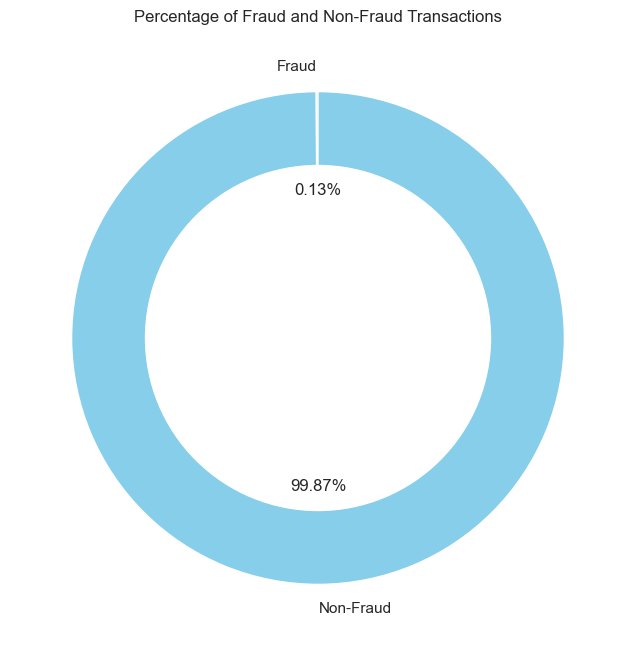

In [27]:
labels = ['Fraud', 'Non-Fraud']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['orange', 'skyblue']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Fraud and Non-Fraud Transactions')
plt.show()

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


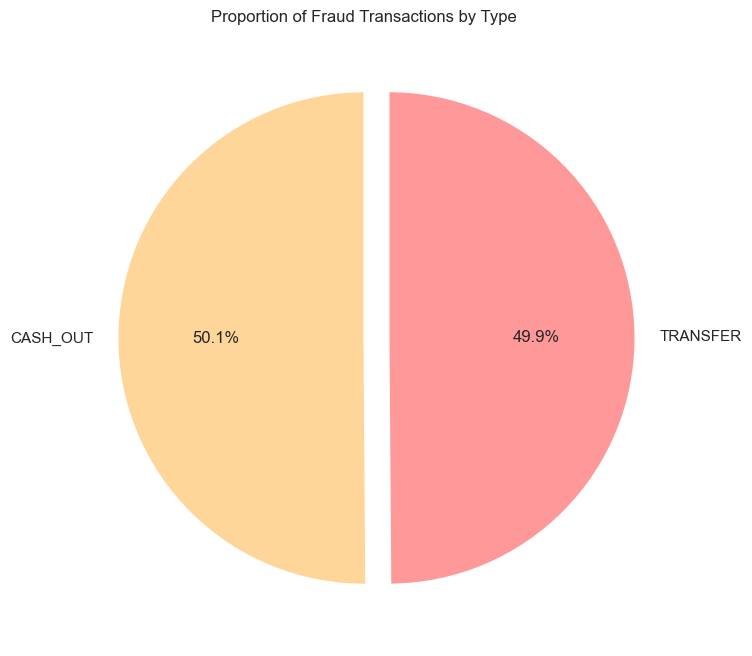

In [28]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_counts_by_type)

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Proportion of Fraud Transactions by Type')
plt.show()

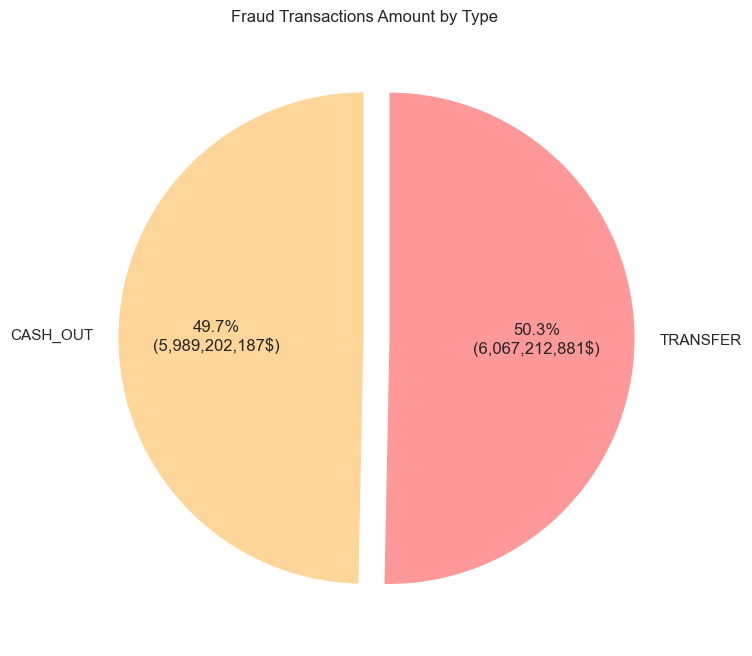

In [29]:
fraud_amounts_by_type = df[df["isFraud"] == 1].groupby("type")["amount"].sum()
plt.figure(figsize=(8, 8))
plt.pie(fraud_amounts_by_type, labels=fraud_amounts_by_type.index, autopct=lambda p: f'{p:.1f}%\n({p * sum(fraud_amounts_by_type) / 100:,.0f}$)', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Fraud Transactions Amount by Type')
plt.show()

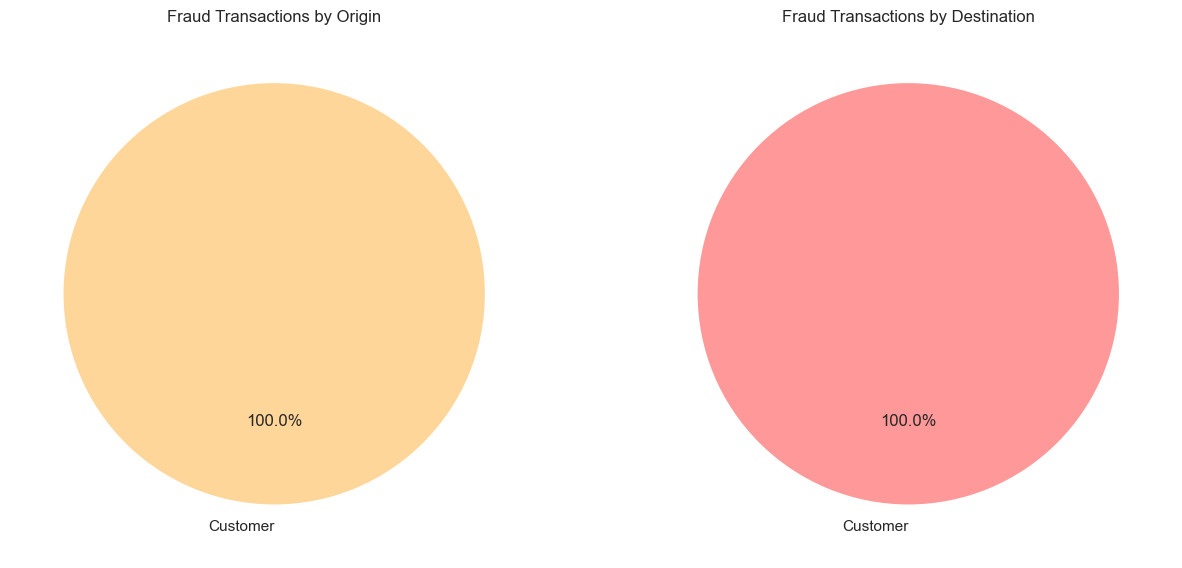

In [30]:
fraud_transactions = df[df['isFraud'] == 1].copy()
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg'].str[0]
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest'].str[0]
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg_first_letter'].replace('C', 'Customer')
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest_first_letter'].replace('C', 'Customer')
fraud_by_name_orig_first_letter = fraud_transactions.groupby('nameOrg_first_letter').size()
fraud_by_name_dest_first_letter = fraud_transactions.groupby('nameDest_first_letter').size()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(fraud_by_name_orig_first_letter, labels=fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange])
axes[0].set_title('Fraud Transactions by Origin')

axes[1].pie(fraud_by_name_dest_first_letter, labels=fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_red])
axes[1].set_title('Fraud Transactions by Destination')

plt.show()

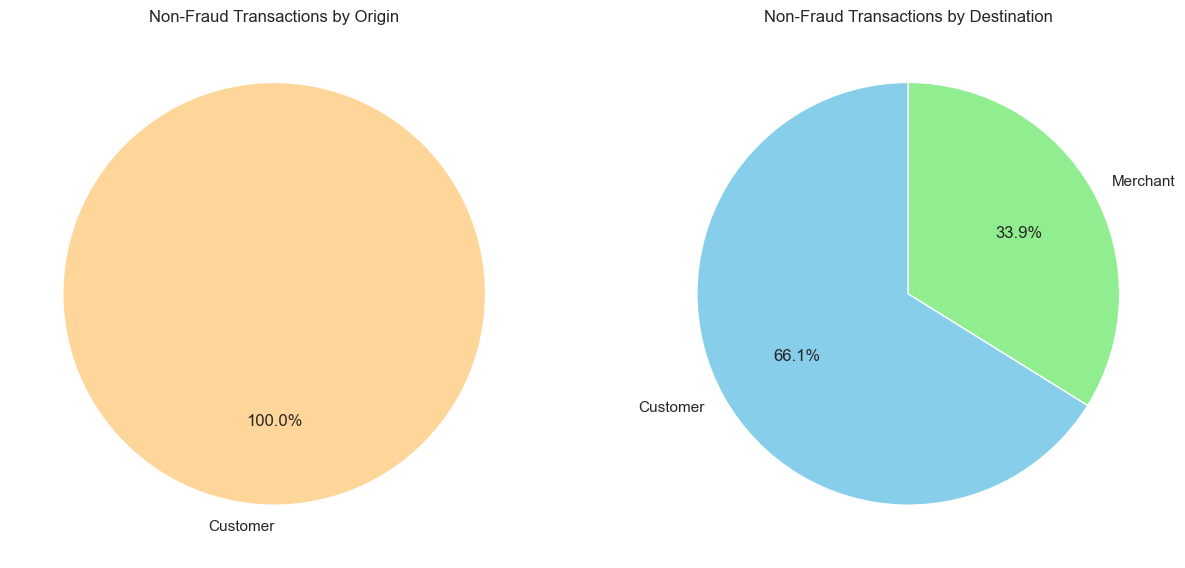

In [31]:
non_fraud_transactions = df[df['isFraud'] == 0].copy()
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg'].str[0]
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest'].str[0]
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})

non_fraud_by_name_orig_first_letter = non_fraud_transactions.groupby('nameOrg_first_letter').size()
non_fraud_by_name_dest_first_letter = non_fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin
axes[0].pie(non_fraud_by_name_orig_first_letter, labels=non_fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, 'lightcoral'])
axes[0].set_title('Non-Fraud Transactions by Origin')

# Pie chart for Non-Fraud Transactions by Destination
axes[1].pie(non_fraud_by_name_dest_first_letter, labels=non_fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].set_title('Non-Fraud Transactions by Destination')

plt.show()

In [32]:
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Statistics on the amounts for non-fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 0].amount), "\n")
print("Statistics on the amounts for fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 1].amount), "\n")

Statistics on the amounts for non-fraud transactions:
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64 

Statistics on the amounts for fraud transactions:
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64 



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


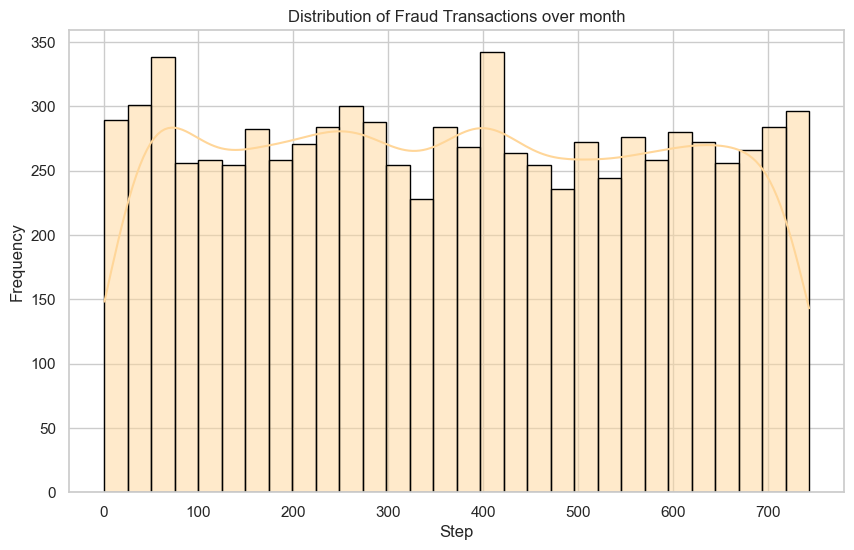

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions["step"], bins=30, kde=True, color=light_orange, edgecolor='black')
plt.title('Distribution of Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


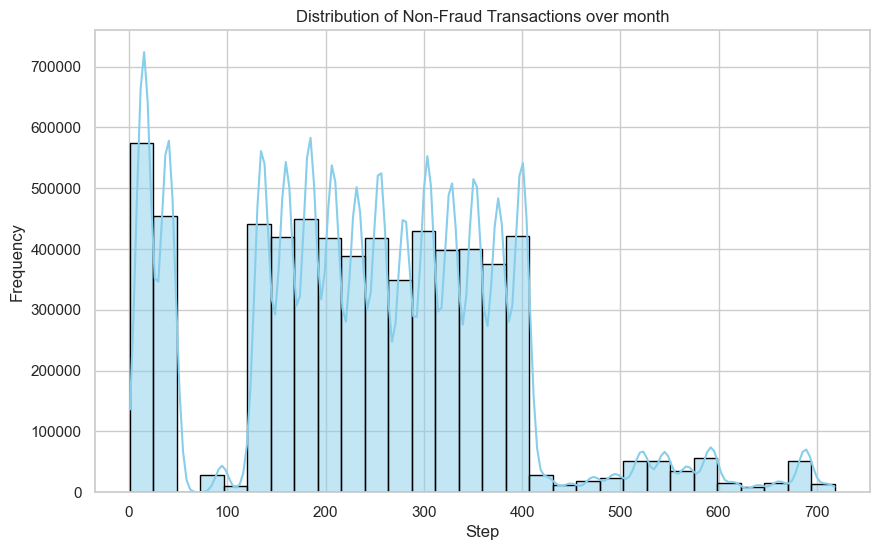

In [34]:
non_fraud_transactions = df[df["isFraud"] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_transactions["step"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

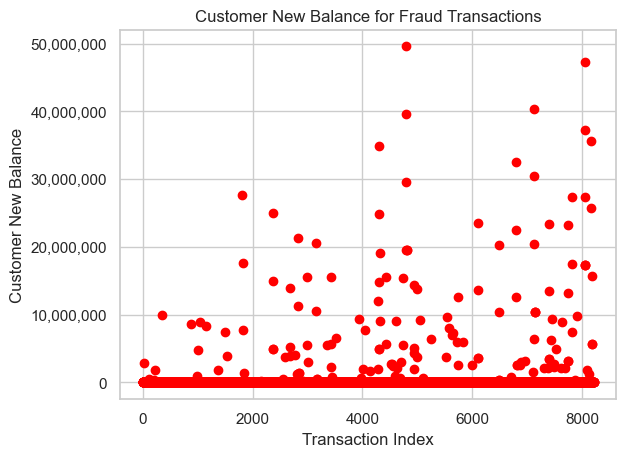

In [35]:
plt.scatter(range(len(fraud_transactions)), fraud_transactions['newbalanceOrg'], color='red')
plt.title('Customer New Balance for Fraud Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Customer New Balance')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.show()

In [36]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

ValueError: could not convert string to float: 'PAYMENT'

In [37]:
process_df = df.copy()

In [38]:
process_df.drop('isFlaggedFraud', axis=1, inplace=True)


In [39]:
types_to_exclude = ['CASH_IN', 'DEBIT', 'PAYMENT']
process_df = process_df[~process_df['type'].isin(types_to_exclude)]

In [40]:
print(f"Total count: {process_df.shape[0]}")

Total count: 2770409


In [41]:
total_transactions = len(process_df)
wrong_org_balance = sum(process_df["oldbalanceOrg"] - process_df["amount"] != process_df["newbalanceOrg"])
wrong_dest_balance = sum(process_df["oldbalanceDest"] + process_df["amount"] != process_df["newbalanceDest"])
percentage_wrong_org_balance = (wrong_org_balance / total_transactions) * 100
percentage_wrong_dest_balance = (wrong_dest_balance / total_transactions) * 100

print(f"Percentage of wrong origin balances: {percentage_wrong_org_balance:.2f}%")
print(f"Percentage of wrong destination balances: {percentage_wrong_dest_balance:.2f}%")

Percentage of wrong origin balances: 93.72%
Percentage of wrong destination balances: 42.09%


In [42]:
process_df.loc[ (process_df["oldbalanceOrg"] == 0) | (process_df["oldbalanceOrg"] < process_df["amount"]), "oldbalanceOrg"] = process_df["amount"]
process_df["newbalanceOrg"] = process_df["oldbalanceOrg"] - process_df["amount"]
process_df["newbalanceDest"] = process_df["oldbalanceDest"] + process_df["amount"]

In [43]:
process_df['isCustomerToCustomer'] = ((process_df['nameOrg'].str.startswith('C').astype(int) == 1) & (process_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

In [45]:
 #process_df.drop(columns=['nameDest', 'nameOrg'], axis=1, inplace=True)Count rows where isCustomerToCustomer is 1 for each category of isFraud
count_by_fraud_customer_to_customer = process_df[process_df['isCustomerToCustomer'] == 1].groupby('isFraud').size()

print("Count of rows with isCustomerToCustomer = 1 by isFraud category:")
print(count_by_fraud_customer_to_customer)
print(f"Total count: {count_by_fraud_customer_to_customer.sum()}")

Count of rows with isCustomerToCustomer = 1 by isFraud category:
isFraud
0    2762196
1       8213
dtype: int64
Total count: 2770409


In [46]:
process_df.drop(columns=['nameDest', 'nameOrg'], axis=1, inplace=True)

In [47]:
label_encoder = LabelEncoder()
process_df['type'] = label_encoder.fit_transform(process_df['type'])

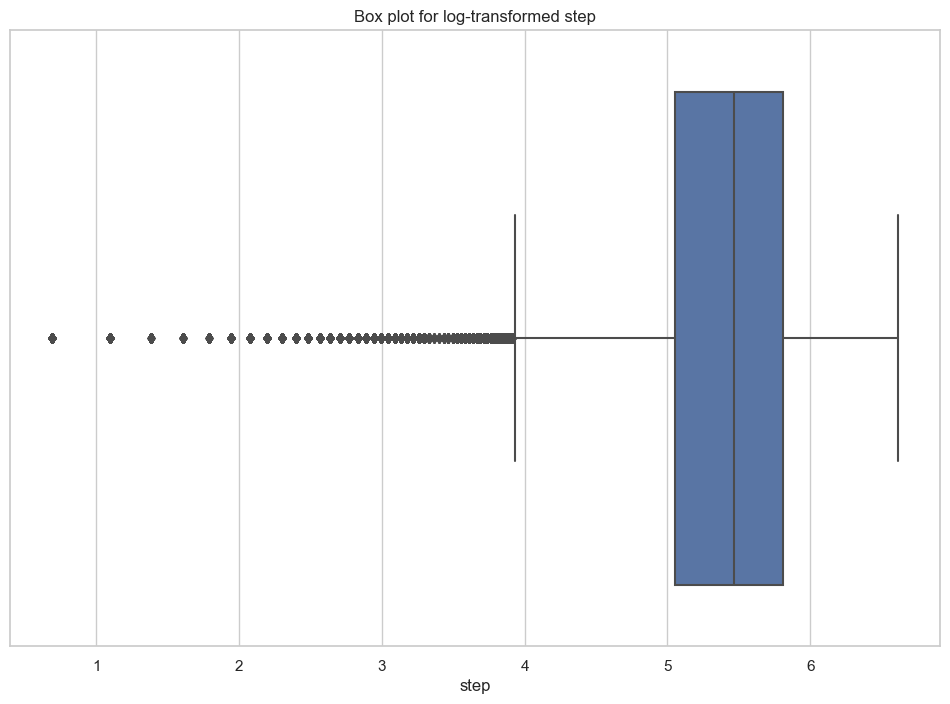

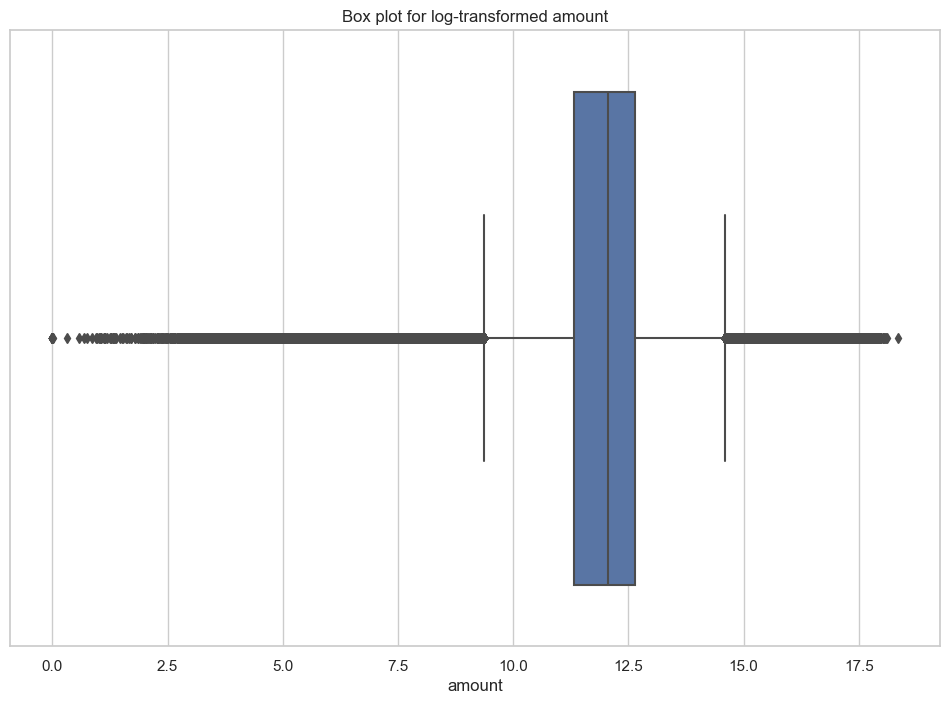

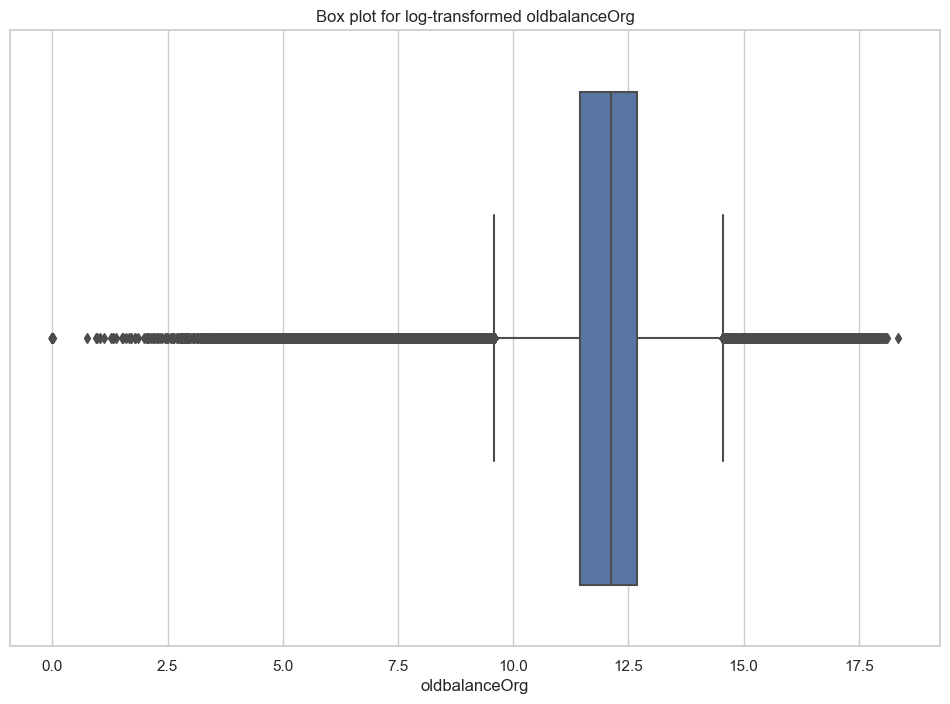

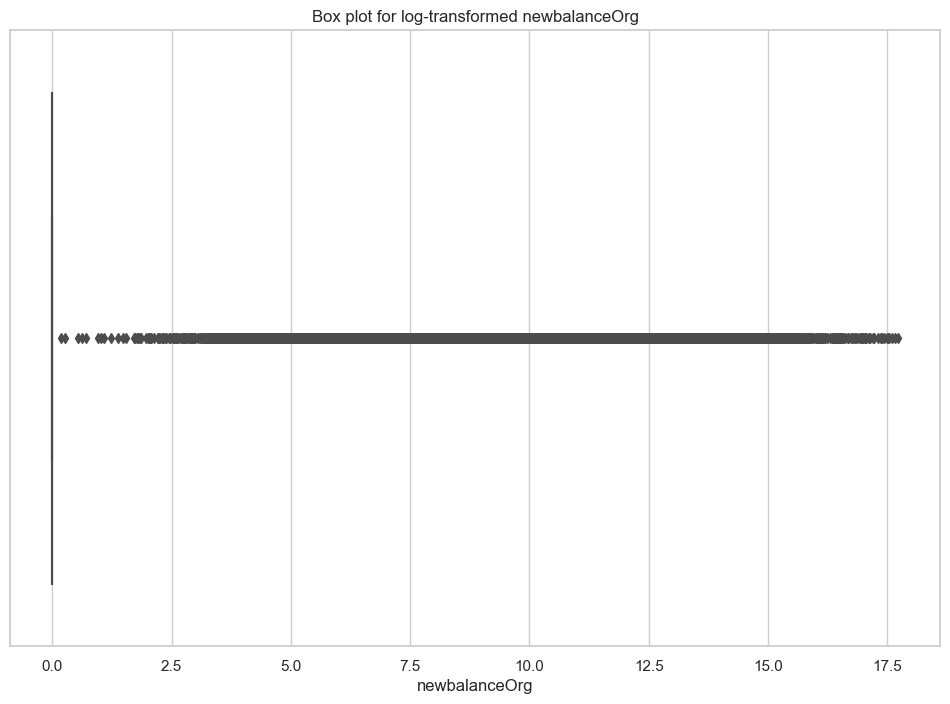

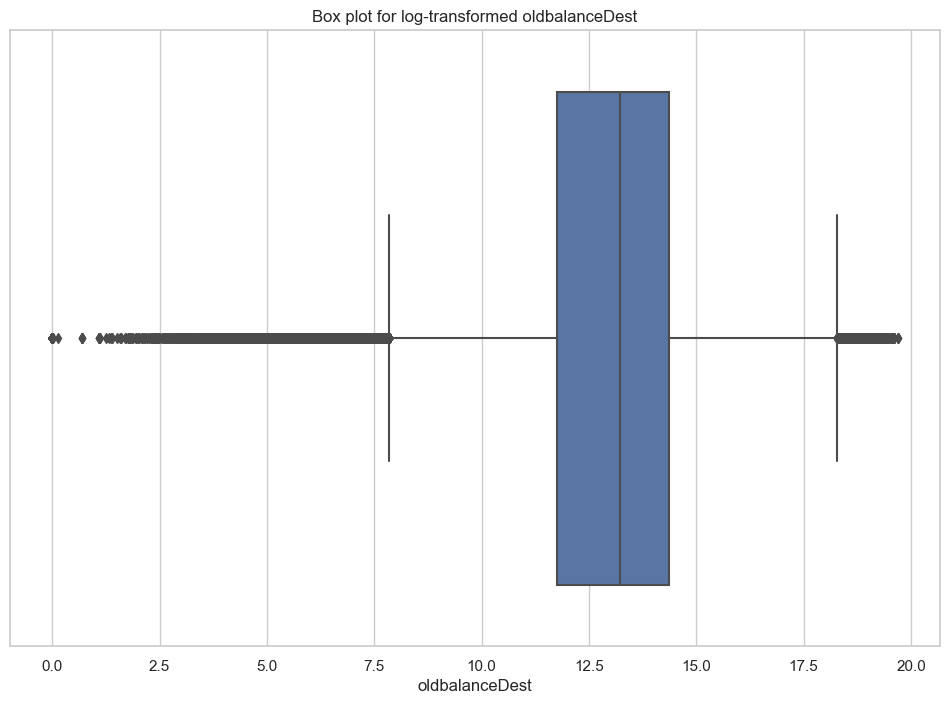

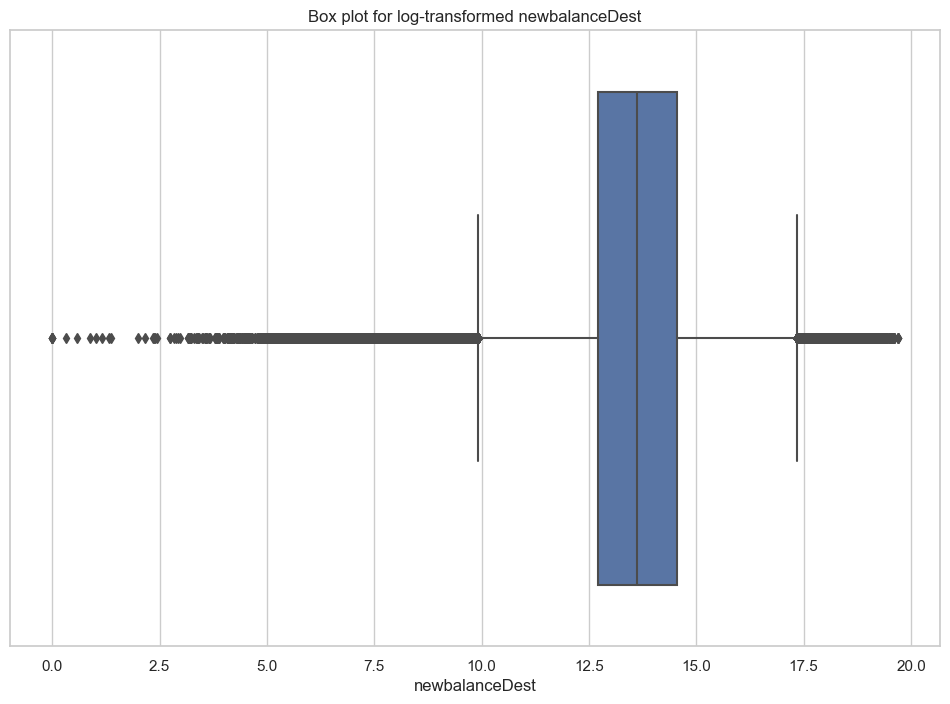

In [48]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']

for column in numeric_columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=np.log1p(process_df[column]))  # Applying log transformation
    plt.title(f'Box plot for log-transformed {column}')
    plt.show()

In [49]:
for column in numeric_columns:
    column_data = process_df[column]
    column_iqr = iqr(column_data)
    print(f"IQR for {column}: {column_iqr}")

IQR for step: 177.0
IQR for amount: 223817.64
IQR for oldbalanceOrg: 231324.15999999997
IQR for newbalanceOrg: 0.0
IQR for oldbalanceDest: 1607826.7
IQR for newbalanceDest: 1765652.54


In [50]:
for column in numeric_columns:
    process_df[column] = np.log1p(process_df[column])

robust_scaler = RobustScaler()
process_df[numeric_columns] = robust_scaler.fit_transform(process_df[numeric_columns])

In [51]:
X = process_df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']]
Y = process_df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [52]:
process_df.drop('isCustomerToCustomer', axis=1, inplace=True)

In [53]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
logreg_model = LogisticRegression(random_state=42)

In [55]:
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, Y_train)

In [56]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score), 
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='f1', return_train_score=True)
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [57]:
print("Class distribution before random undersampling:")
print(Y_train.value_counts())

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, Y_train)

print("\nClass distribution after random undersampling:")
print(y_train_under_sampled.value_counts())

Class distribution before random undersampling:
isFraud
0    2209757
1       6570
Name: count, dtype: int64

Class distribution after random undersampling:
isFraud
0    65700
1     6570
Name: count, dtype: int64


In [58]:
grid_search_sampled = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='roc_auc', return_train_score=True)
grid_search_sampled.fit(X_train_under_sampled, y_train_under_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [59]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Before under sampling:")
print("   Best Hyperparameters:", best_params)
print("   Best Score:", best_score)

best_params_sampled = grid_search_sampled.best_params_
best_score_sampled = grid_search_sampled.best_score_

print("After under sampling:")
print("   Best Hyperparameters:", best_params_sampled)
print("   Best Score:", best_score_sampled)

Before under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.4433201731547515
After under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.6526027397260273


In [60]:
best_logistic_over_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_over_sampled.fit(X_train_over_sampled, y_train_over_sampled)

LogisticRegression(C=10, random_state=42)

In [61]:
best_logistic_under_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_under_sampled.fit(X_train_under_sampled, y_train_under_sampled)

LogisticRegression(C=10, random_state=42)

In [62]:
y_pred = best_logistic_over_sampled.predict(X_test)
predicted_probabilities = best_logistic_over_sampled.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print("Oversampled:")
print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

y_pred_sampled = best_logistic_under_sampled.predict(X_test)
predicted_probabilities_sampled = best_logistic_under_sampled.predict_proba(X_test)
mcc_sampled = matthews_corrcoef(Y_test, y_pred_sampled)

print("\nUndersampled:")
print(classification_report(Y_test, y_pred_sampled))
print(f'Matthews Correlation Coefficient: {mcc_sampled:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities_sampled[:, 1]):.2f}')

Oversampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.33      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.16
ROC-AUC Score: 0.84

Undersampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.32      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.15
ROC-AUC Score: 0.84


[[546163   6276]
 [  1108    535]]


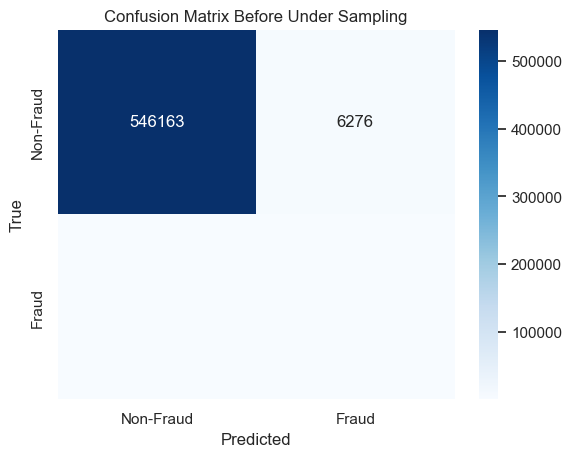

[[546159   6280]
 [  1110    533]]


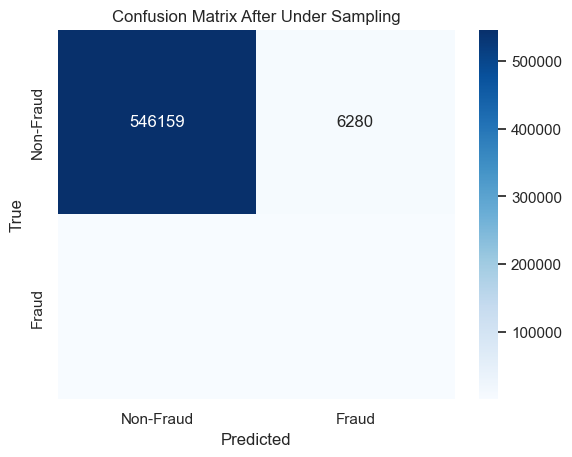

In [63]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(Y_test, y_pred, 'Confusion Matrix Before Under Sampling')
plot_confusion_matrix(Y_test, y_pred_sampled, 'Confusion Matrix After Under Sampling')
plt.show()

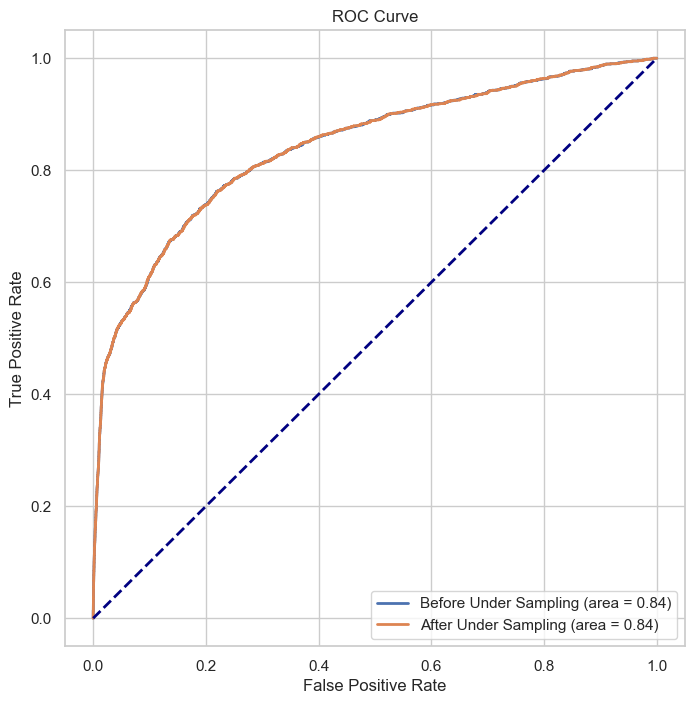

In [64]:
def plot_roc_curve(Y_test, predicted_probabilities, label):
    fpr, tpr, _ = roc_curve(Y_test, predicted_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

plt.figure(figsize=(8, 8))
plot_roc_curve(Y_test, predicted_probabilities, 'Before Under Sampling')
plot_roc_curve(Y_test, predicted_probabilities_sampled, 'After Under Sampling')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [65]:
rf_model = RandomForestClassifier(random_state=42)

In [66]:
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}
random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}


In [67]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=150)

In [68]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.09      0.78      0.16      1643

    accuracy                           0.98    554082
   macro avg       0.54      0.88      0.57    554082
weighted avg       1.00      0.98      0.98    554082

Matthews Correlation Coefficient: 0.26
ROC-AUC Score: 0.95


[[538958  13481]
 [   360   1283]]


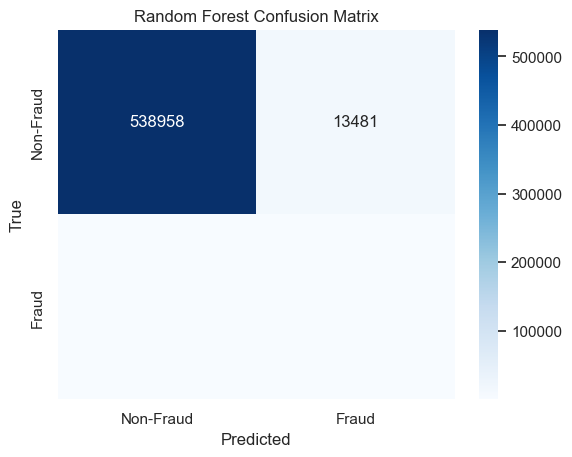

In [69]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

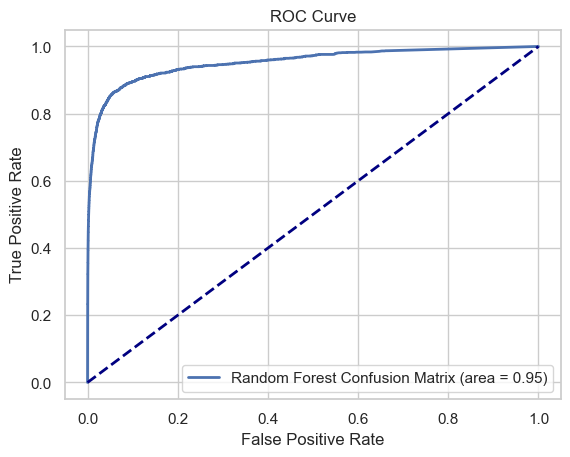

In [70]:
plot_roc_curve(Y_test, predicted_probabilities, 'Random Forest Confusion Matrix')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

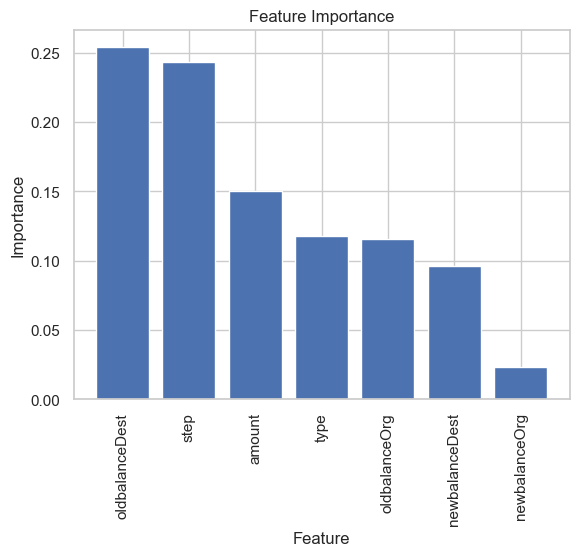

In [71]:
feature_importances = random_search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(X_train_under_sampled.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train_under_sampled.shape[1]), X_train_under_sampled.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

In [75]:
pip install xgboost


  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl (1.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [76]:
import xgboost as xgb

In [77]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1] 
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

# Fit the model to your training data
random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'alpha': [0, 0.1, 0.5, 1],
                                        'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

In [78]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 0}


In [79]:
best_xgb_model = xgb.XGBClassifier(**random_search_xgb.best_params_, random_state=42)
best_xgb_model.fit(X_train_under_sampled, y_train_under_sampled)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, ...)

In [80]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.18      0.73      0.29      1643

    accuracy                           0.99    554082
   macro avg       0.59      0.86      0.64    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.36
ROC-AUC Score: 0.97


[[547057   5382]
 [   441   1202]]


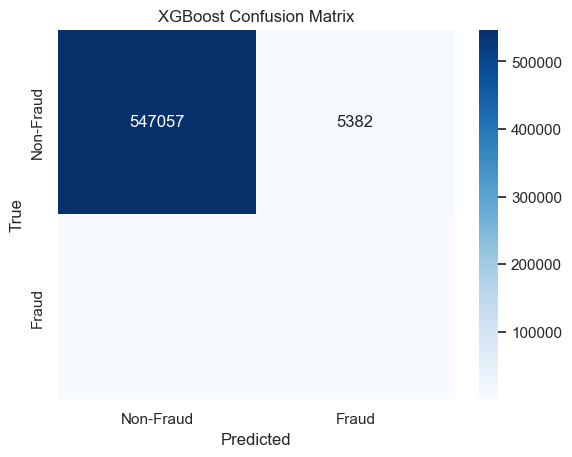

In [81]:
plot_confusion_matrix(Y_test, y_pred, 'XGBoost Confusion Matrix')
plt.show()

In [82]:
knn_model = KNeighborsClassifier()

In [83]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'p': [1, 2, 3]
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search = RandomizedSearchCV(knn_model, param_distributions=param_grid, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto'],
                                        'leaf_size': [10, 30, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

In [84]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'chebyshev', 'leaf_size': 30, 'algorithm': 'auto'}


In [85]:
best_knn_model = KNeighborsClassifier(**random_search.best_params_)
best_knn_model.fit(X_train_under_sampled, y_train_under_sampled)

KNeighborsClassifier(metric='chebyshev')

[[547057   5382]
 [   441   1202]]


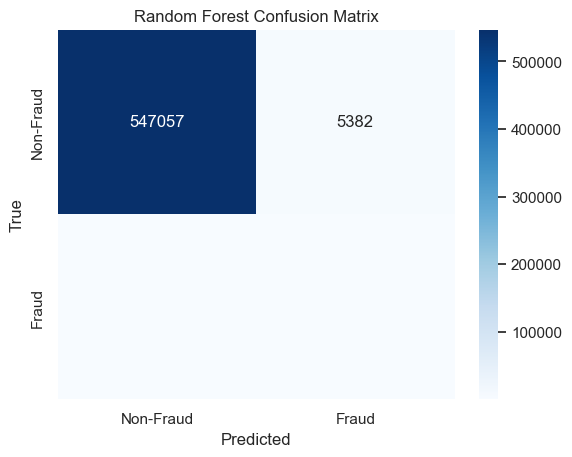

In [86]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

In [87]:
y_pred = best_knn_model.predict(X_test)
predicted_probabilities = best_knn_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.13      0.67      0.22      1643

    accuracy                           0.99    554082
   macro avg       0.57      0.83      0.61    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.29
ROC-AUC Score: 0.90
